In [1]:
pip install hotspotsc 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import hotspot 
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings

In [2]:
adata = ad.read_h5ad("adata_bb_30kgenes.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 33674 × 32471
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'cond', 'pct_mt', 'RNA_snn_res.1.3', 'seurat_clusters', 'seuratclusters53', 'RNA_snn_res.0.02', 'seuratclusters15', 'RNA_snn_res.0.018', 'RNA_snn_res.0.015', 'seuratclusters14', 'subsample', 'sub', 'p', 'depth', 'gsi', 'good_names', 'good15_names', 'good_names_num', 'cc', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'cyto', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'velocity_self_transition', 'demux', 'trial_id', 'pid', 'build_15_45', 'build_25_55', 'build_35_65', 'build_45_75', 'build_5_35', 'build_55_85', 'build_65_95', 'depth_15_45', 'depth_25_55', 'depth_35_65', 'depth_45_75', 'depth_5_35', 'depth_55_85', 'depth_65_95', 'spawn_15_45', 'spawn_25_55', 'spawn_35_65', 'spawn_45_75', 'spawn_5_35', 'spawn_55_85', 'spawn_65_95', 'ieg_score', 'neurogen_score', 'fst_score', 'pair', 'build_events', 'spawn_events', 'standard_length', 'run', 'build_35_75', 

In [3]:
pip install muon

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy 

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mplscience

Note: you may need to restart the kernel to use updated packages.


In [6]:
import hotspot
import scanpy as sc

import numpy as np
import mplscience

In [7]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)
adata.layers["counts"] = adata.X.copy()


In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


In [9]:
adata.layers["log_normalized"] = adata.X.copy()


In [10]:
sc.tl.pca(adata, n_comps=10)

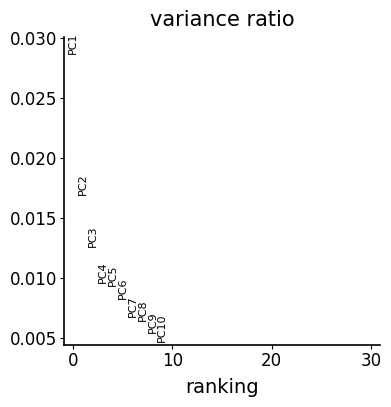

In [11]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 26296 × 21782
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'cond', 'pct_mt', 'RNA_snn_res.1.3', 'seurat_clusters', 'seuratclusters53', 'RNA_snn_res.0.02', 'seuratclusters15', 'RNA_snn_res.0.018', 'RNA_snn_res.0.015', 'seuratclusters14', 'subsample', 'sub', 'p', 'depth', 'gsi', 'good_names', 'good15_names', 'good_names_num', 'cc', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'cyto', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'velocity_self_transition', 'demux', 'trial_id', 'pid', 'build_15_45', 'build_25_55', 'build_35_65', 'build_45_75', 'build_5_35', 'build_55_85', 'build_65_95', 'depth_15_45', 'depth_25_55', 'depth_35_65', 'depth_45_75', 'depth_5_35', 'depth_55_85', 'depth_65_95', 'spawn_15_45', 'spawn_25_55', 'spawn_35_65', 'spawn_45_75', 'spawn_5_35', 'spawn_55_85', 'spawn_65_95', 'ieg_score', 'neurogen_score', 'fst_score', 'pair', 'build_events', 'spawn_events', 'standard_length', 'run', 'build_35_75', 

In [13]:
adata.layers["counts_csc"] = adata.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="nCount_RNA"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [14]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

100%|████████████████████████████████████████████████████████████████████████████| 21782/21782 [00:40<00:00, 536.87it/s]


,C,Z,Pval,FDR
Gene,,,,
gpm6b,0.686023,883.831618,0.0,0.0
swap70,0.708471,878.417432,0.0,0.0
LOC101464395,0.697438,860.421520,0.0,0.0
slc1a2,0.771210,847.955186,0.0,0.0
LOC101467477,0.786607,774.976234,0.0,0.0
LOC101480016,0.614881,707.821763,0.0,0.0
LOC101481569,0.812146,693.921141,0.0,0.0
LOC101482034,0.619650,689.642804,0.0,0.0
slc4a4,0.577783,648.275842,0.0,0.0


In [15]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)

Computing pair-wise local correlation on 500 features...


100%|█████████████████████████████████████████████████████████████████████████| 124750/124750 [01:48<00:00, 1152.01it/s]


In [16]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

Module
-1     93
 1     85
 4     56
 5     52
 3     43
 2     34
 8     28
 10    25
 12    21
 7     17
 11    16
 6     15
 9     15
Name: count, dtype: int64

In [17]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [18]:
module = 1

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
gpm6b,0.686023,883.831618,0.0,0.0,1.0
swap70,0.708471,878.417432,0.0,0.0,1.0
LOC101464395,0.697438,860.421520,0.0,0.0,1.0
slc1a2,0.771210,847.955186,0.0,0.0,1.0
LOC101480016,0.614881,707.821763,0.0,0.0,1.0
LOC101482034,0.619650,689.642804,0.0,0.0,1.0
slc4a4,0.577783,648.275842,0.0,0.0,1.0
prex1,0.577613,642.570893,0.0,0.0,1.0
LOC101483975,0.554223,602.471562,0.0,0.0,1.0


In [50]:
results.index

Index(['gpm6b', 'swap70', 'LOC101464395', 'slc1a2', 'LOC101480016',
       'LOC101482034', 'slc4a4', 'prex1', 'LOC101483975', 'fgfr2', 'atp1b4',
       'LOC101487307', 'LOC101488128', 'LOC101486280', 'npas3', 'LOC101470384',
       'mlc1', 'LOC101470091', 'prex2', 'dock1', 'cobl', 'lrig1', 'wdr73',
       'tns1', 'LOC101471239', 'fat4', 'LOC112430353', 'LOC101467518',
       'LOC101481538', 'hhla1', 'LOC101482932', 'LOC101479289', 'rgs3',
       'LOC101483810', 'LOC101463785', 'LOC101471711', 'LOC101484507', 'axl',
       'LOC101475969', 'megf10', 'LOC101467905', 'LOC101466093',
       'LOC101470430', 'fabp7', 'LOC101467202', 'LOC101471215', 'LOC101484797',
       'LOC101477204', 'LOC101479283', 'LOC105941323', 'LOC101470425', 'npas1',
       'plpp3', 'LOC101477672', 'LOC101479510', 'veph1', 'LOC101476769',
       'arap1', 'gli1', 'LOC101475072', 'LOC106676353', 'LOC101468980',
       'LOC101487121', 'LOC101473609', 'LOC106675461', 'LOC101470175',
       'LOC101484174', 'LOC105941327',

In [19]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 12 modules...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


,1,2,3,4,5,6,7,8,9,10,11,12
BHVE_AAACCCACACAATCTG-1_1,-0.211800,-0.778177,-1.761421,-0.580291,-0.368116,-1.128234,-1.115658,1.916658,0.694451,0.924164,-0.111032,2.468681
BHVE_AAACCCATCGGACGTC-1_1,-0.767525,-0.600128,8.715427,-1.472646,-0.396605,2.365464,-0.314834,-1.433461,-1.136932,-0.027716,-1.224984,-2.634514
BHVE_AAACGAAGTAGAAACT-1_1,-0.451046,0.193095,-0.709420,-0.594703,1.428968,1.124249,-0.907377,-0.806559,-1.233514,-0.344652,-0.109418,-2.242182
BHVE_AAACGAATCTAACGGT-1_1,-1.054135,-0.657101,-2.007640,-1.094591,-1.515660,-1.508234,0.311025,7.551797,-0.137666,-0.805223,-0.571115,1.724087
BHVE_AAACGCTCACGATTCA-1_1,-0.890064,-0.608128,-2.123124,-1.007923,-0.885201,-1.499711,-0.857701,2.318612,-0.359370,-0.681790,0.472421,1.836645


In [20]:
module_scores

,1,2,3,4,5,6,7,8,9,10,11,12
BHVE_AAACCCACACAATCTG-1_1,-0.211800,-0.778177,-1.761421,-0.580291,-0.368116,-1.128234,-1.115658,1.916658,0.694451,0.924164,-0.111032,2.468681
BHVE_AAACCCATCGGACGTC-1_1,-0.767525,-0.600128,8.715427,-1.472646,-0.396605,2.365464,-0.314834,-1.433461,-1.136932,-0.027716,-1.224984,-2.634514
BHVE_AAACGAAGTAGAAACT-1_1,-0.451046,0.193095,-0.709420,-0.594703,1.428968,1.124249,-0.907377,-0.806559,-1.233514,-0.344652,-0.109418,-2.242182
BHVE_AAACGAATCTAACGGT-1_1,-1.054135,-0.657101,-2.007640,-1.094591,-1.515660,-1.508234,0.311025,7.551797,-0.137666,-0.805223,-0.571115,1.724087
BHVE_AAACGCTCACGATTCA-1_1,-0.890064,-0.608128,-2.123124,-1.007923,-0.885201,-1.499711,-0.857701,2.318612,-0.359370,-0.681790,0.472421,1.836645
...,...,...,...,...,...,...,...,...,...,...,...,...
CTRL_TTTGTTGCAGTAACCT-1_10,-0.766330,-0.455018,6.340391,0.136695,0.178791,4.103177,-0.588983,-1.673061,-1.452872,0.243877,-0.493228,-2.655812
CTRL_TTTGTTGTCACTACGA-1_10,-1.115864,-0.620292,-2.539984,-0.881467,-1.539418,-1.677979,6.671014,0.382977,4.816027,-0.943084,-1.020502,0.450030
CTRL_TTTGTTGTCATCACTT-1_10,-0.759761,-0.266412,-1.997021,-1.593158,-1.120983,-1.532277,-1.446975,-0.326991,-0.888456,-1.136223,4.316417,2.377404
CTRL_TTTGTTGTCCAAGCTA-1_10,-0.861479,-0.812393,7.634000,-1.235593,-0.746797,1.967013,0.864280,-0.560745,-0.991019,0.032043,-1.245870,-2.239246


In [21]:
def extract_condition(index):
    if index.startswith('BHVE'):
        return 'BHVE'
    elif index.startswith('CTRL'):
        return 'CTRL'
    else:
        return None

# Apply the function to create the 'Condition' column
module_scores['Condition'] = module_scores.index.to_series().apply(extract_condition)

In [22]:
module_scores

,1,2,3,4,5,6,7,8,9,10,11,12,Condition
BHVE_AAACCCACACAATCTG-1_1,-0.211800,-0.778177,-1.761421,-0.580291,-0.368116,-1.128234,-1.115658,1.916658,0.694451,0.924164,-0.111032,2.468681,BHVE
BHVE_AAACCCATCGGACGTC-1_1,-0.767525,-0.600128,8.715427,-1.472646,-0.396605,2.365464,-0.314834,-1.433461,-1.136932,-0.027716,-1.224984,-2.634514,BHVE
BHVE_AAACGAAGTAGAAACT-1_1,-0.451046,0.193095,-0.709420,-0.594703,1.428968,1.124249,-0.907377,-0.806559,-1.233514,-0.344652,-0.109418,-2.242182,BHVE
BHVE_AAACGAATCTAACGGT-1_1,-1.054135,-0.657101,-2.007640,-1.094591,-1.515660,-1.508234,0.311025,7.551797,-0.137666,-0.805223,-0.571115,1.724087,BHVE
BHVE_AAACGCTCACGATTCA-1_1,-0.890064,-0.608128,-2.123124,-1.007923,-0.885201,-1.499711,-0.857701,2.318612,-0.359370,-0.681790,0.472421,1.836645,BHVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTRL_TTTGTTGCAGTAACCT-1_10,-0.766330,-0.455018,6.340391,0.136695,0.178791,4.103177,-0.588983,-1.673061,-1.452872,0.243877,-0.493228,-2.655812,CTRL
CTRL_TTTGTTGTCACTACGA-1_10,-1.115864,-0.620292,-2.539984,-0.881467,-1.539418,-1.677979,6.671014,0.382977,4.816027,-0.943084,-1.020502,0.450030,CTRL
CTRL_TTTGTTGTCATCACTT-1_10,-0.759761,-0.266412,-1.997021,-1.593158,-1.120983,-1.532277,-1.446975,-0.326991,-0.888456,-1.136223,4.316417,2.377404,CTRL
CTRL_TTTGTTGTCCAAGCTA-1_10,-0.861479,-0.812393,7.634000,-1.235593,-0.746797,1.967013,0.864280,-0.560745,-0.991019,0.032043,-1.245870,-2.239246,CTRL


/home/asmilags/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-26 08:51:06.352273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 08:51:06.432990: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 08:51:06.729444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 08:51:06.729502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] U

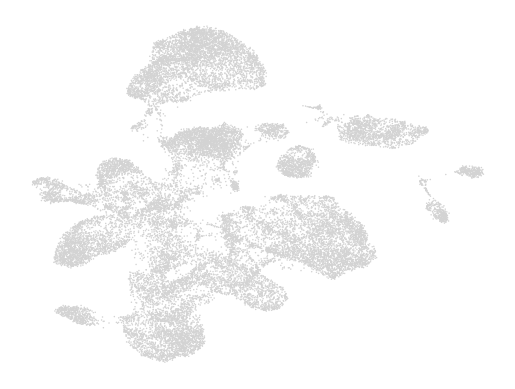

In [32]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, frameon=False)

In [33]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

In [34]:
module_cols

['Module 1',
 'Module 2',
 'Module 3',
 'Module 4',
 'Module 5',
 'Module 6',
 'Module 7',
 'Module 8',
 'Module 9',
 'Module 10',
 'Module 11',
 'Module 12',
 'Module Condition']

In [35]:
adata

AnnData object with n_obs × n_vars = 26296 × 21782
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'cond', 'pct_mt', 'RNA_snn_res.1.3', 'seurat_clusters', 'seuratclusters53', 'RNA_snn_res.0.02', 'seuratclusters15', 'RNA_snn_res.0.018', 'RNA_snn_res.0.015', 'seuratclusters14', 'subsample', 'sub', 'p', 'depth', 'gsi', 'good_names', 'good15_names', 'good_names_num', 'cc', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'cyto', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'velocity_self_transition', 'demux', 'trial_id', 'pid', 'build_15_45', 'build_25_55', 'build_35_65', 'build_45_75', 'build_5_35', 'build_55_85', 'build_65_95', 'depth_15_45', 'depth_25_55', 'depth_35_65', 'depth_45_75', 'depth_5_35', 'depth_55_85', 'depth_65_95', 'spawn_15_45', 'spawn_25_55', 'spawn_35_65', 'spawn_45_75', 'spawn_5_35', 'spawn_55_85', 'spawn_65_95', 'ieg_score', 'neurogen_score', 'fst_score', 'pair', 'build_events', 'spawn_events', 'standard_length', 'run', 'build_35_75', 

/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 966x400 with 0 Axes>

<Figure size 1932x2.6296e+06 with 0 Axes>

<Figure size 1932x2.6296e+06 with 0 Axes>

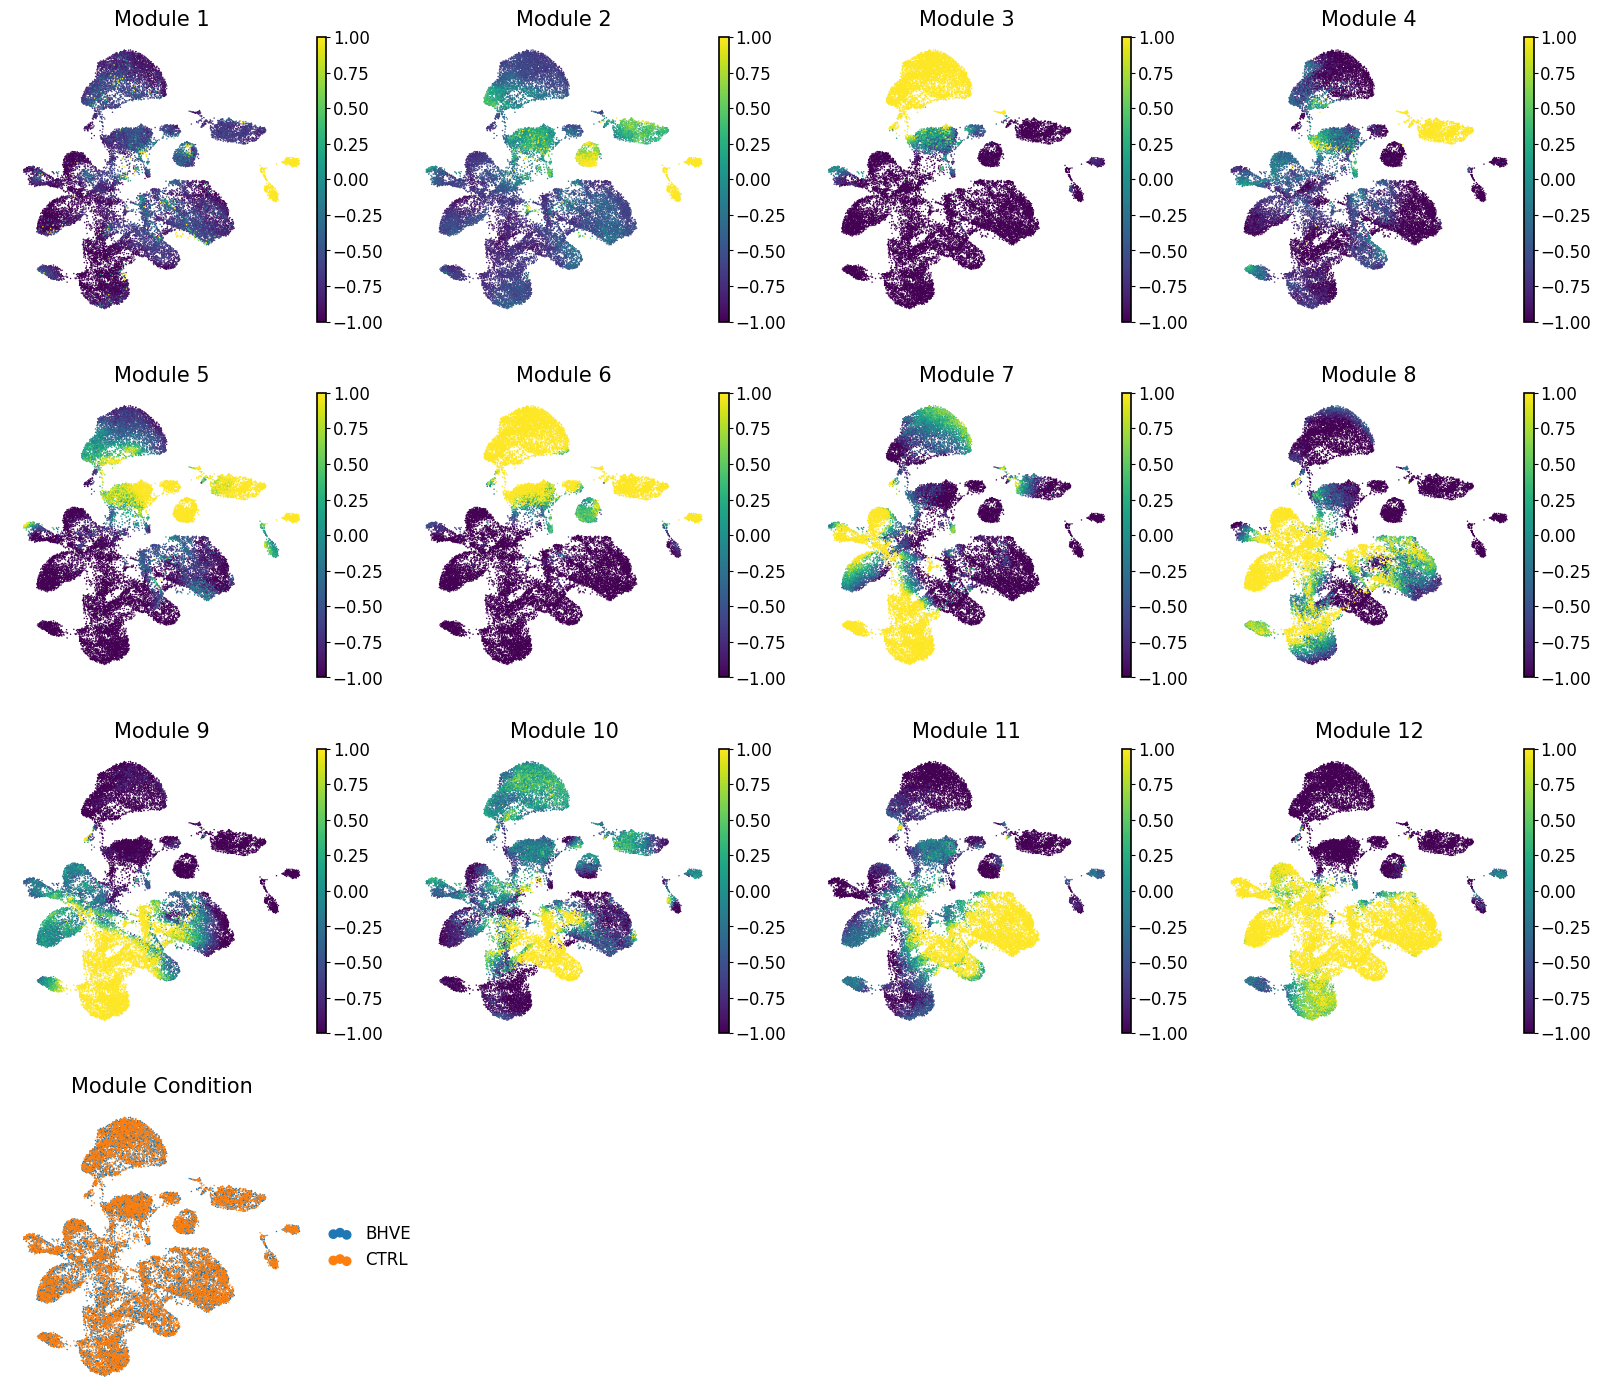

In [43]:
with mplscience.style_context():
    sc.pl.umap(adata, color= module_cols,frameon=False, vmin=-1, vmax=1)

/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


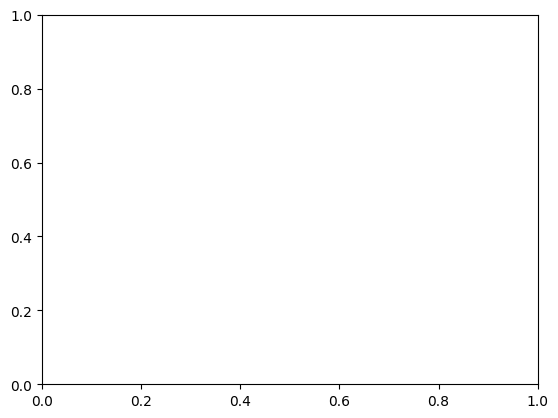

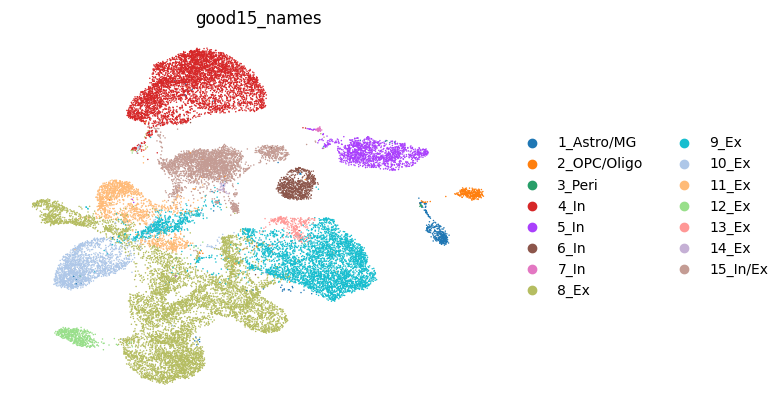

In [49]:
sc.pl.umap(adata, color= "good15_names" ,frameon=False, vmin=-1, vmax=1)

/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/asmilags/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


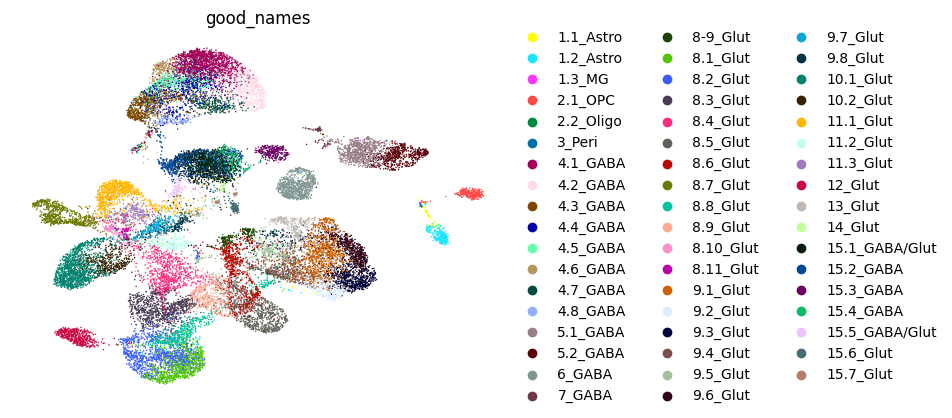

In [51]:
sc.pl.umap(adata, color= "good_names" ,frameon=False, vmin=-1, vmax=1)